In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from dmba import classificationSummary
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

# Neural Networks

In [197]:
df = pd.read_csv('gym_members_exercise_tracking.csv')
df.sample(5)


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
11,53,Male,51.7,1.70,175,152,72,1.15,865.0,HIIT,23.6,3.5,3,2,17.89
868,47,Male,127.8,1.65,198,157,60,0.77,598.0,Cardio,28.7,3.5,2,1,46.94
484,42,Male,85.2,1.81,189,151,65,1.54,1151.0,Yoga,13.7,3.5,5,3,26.01
833,59,Male,126.4,1.69,168,149,68,1.24,915.0,Strength,29.5,2.9,3,1,44.26
677,40,Female,52.6,1.66,198,120,71,1.27,762.0,Strength,32.9,1.7,3,2,19.09


* Workout frequency at least 2 times a week
* Experience level at least 1
* Duration of at least 1 hour
* Age is less than 50
* Fat percentage is less than 60
* Calories burned greater than 500
* Max bpm is less than 190
* BMI is greater than 27

In [198]:
outcome = 'Renew'

df['Renew'] = (
    (df["Workout_Frequency (days/week)"] >= 2) &
    (df["Experience_Level"] >= 1) &
    (df["Session_Duration (hours)"] >= 1) &
    (df["Age"] <=60) &
    (df["Fat_Percentage"] <= 60) &
    (df["Calories_Burned"] >= 500) &
    (df["Max_BPM"] <= 190) &
    (df["BMI"] <= 27)
).astype(int)
# 0 is Neagtive, 1 is Positive
df['Renew'].value_counts()

Renew
0    564
1    409
Name: count, dtype: int64

# Scaling and Splitting 

In [199]:
processed = pd.get_dummies(df, columns=['Gender','Workout_Type'])
predictors = ['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM',
       'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage',
       'Water_Intake (liters)', 'Workout_Frequency (days/week)',
       'Experience_Level', 'BMI', 'Gender_Female', 'Gender_Male',
       'Workout_Type_Cardio', 'Workout_Type_HIIT', 'Workout_Type_Strength',
       'Workout_Type_Yoga']

In [200]:
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=42,stratify=y)

In [201]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X) 
# activation='relu' for prediction
# activation='logistic' for classification
smote = SMOTE(random_state=42)
train_X_resampled, train_y_resampled = smote.fit_resample(train_X_scaled, train_y)
clf = MLPClassifier(
    hidden_layer_sizes=(50, 25),   
    activation='relu',             
    max_iter=500,
    random_state=42
)
clf.fit(train_X_resampled, train_y_resampled)


,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(50, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",500
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


# Data Calculations

* Accuracy 
* Precision 
* Recall 
* Confusion matrix

In [202]:
#Predict 
train_pred = clf.predict(train_X_scaled)
valid_pred = clf.predict(valid_X_scaled)

## Confusion Matrix and accuracy

In [203]:
classificationSummary(train_y, clf.predict(train_X_scaled))
classificationSummary(valid_y, clf.predict(valid_X_scaled))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 338   0
     1   0 245
Confusion Matrix (Accuracy 0.9077)

       Prediction
Actual   0   1
     0 210  16
     1  20 144


## Recall

In [204]:

recall_score(train_y, train_pred),recall_score(valid_y, valid_pred)

(1.0, 0.8780487804878049)

## Precision

In [205]:
precision_score(train_y, train_pred),precision_score(valid_y, valid_pred)

(1.0, 0.9)

## Classification Report

In [206]:
from sklearn.metrics import classification_report
print(classification_report(valid_y, valid_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       226
           1       0.90      0.88      0.89       164

    accuracy                           0.91       390
   macro avg       0.91      0.90      0.90       390
weighted avg       0.91      0.91      0.91       390



C:\Users\Zane\AppData\Local\Temp\ipykernel_36956\2539943533.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


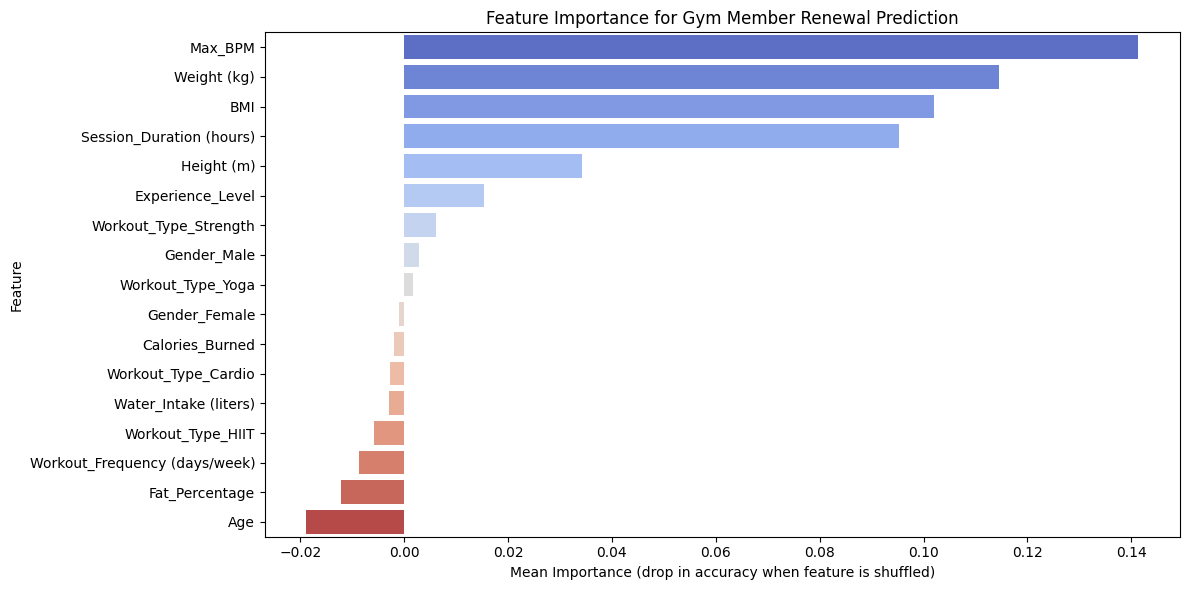

In [207]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate permutation importance
perm_importance = permutation_importance(
    clf, 
    valid_X_scaled, 
    valid_y, 
    n_repeats=30,
    random_state=42
)

# Put results in a DataFrame
importance_df = pd.DataFrame({
    'Feature': predictors,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=importance_df, 
    x='Importance', 
    y='Feature',
    palette='coolwarm'
)
plt.title('Feature Importance for Gym Member Renewal Prediction')
plt.xlabel('Mean Importance (drop in accuracy when feature is shuffled)')
plt.tight_layout()
plt.show()